# scGen for multi-omic integration

In [1]:
import scgen
import anndata
import numpy as np
import scanpy as sc
import pandas as pd
import tensorflow as tf

Using TensorFlow backend.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jovyan/my-c

Using PBMC data used in LIGER tutorial (downloaded from [here](https://umich.app.box.com/s/5hkhpou4inrulo570yhc38ay8g3ont5b))

In [231]:
train = sc.read_10x_h5('/home/jovyan/10X_data/intPBMC_10x.hdf5')
atac_clust = pd.read_csv('/home/jovyan/10X_data/atac_cluster_assignments.csv', )
rna_clust = pd.read_csv('/home/jovyan/10X_data/rna_cluster_assignments.csv')
        
rna_clust.columns = ['cell_id', 'cell_type']
atac_clust.columns = ['cell_id', 'cell_type']

### Add cluster and batch information to `train.obs`

In [232]:
train.obs.index.name = 'cell_id'
# train.obs.reset_index(inplace=True)
# # train.obs=pd.merge(train.obs, rna_clust, how="left", sort=False).set_index('cell_id')


In [233]:
train_clust = pd.concat([rna_clust, atac_clust])
train_clust = train_clust.assign(batch= [np.where(x[:8]=="pbmc.rna", "RNA", "ATAC") for x in train_clust['cell_id']])


In [211]:
train.obs = pd.merge(train.obs, train_clust, how="outer", left_index=True, right_on="cell_id").set_index('cell_id')

In [245]:
# train.obs.reset_index(inplace=True)
train.obs = train.obs.reset_index(inplace=True)
train.obs.assign(batch= [np.where(x[:8]=="pbmc.rna", "RNA", "ATAC") for x in train.obs['cell_id']])

ValueError: Can only assign pd.DataFrame.

In [249]:
train.obs = train.obs.assign(batch= [np.where(x[:8]=="pbmc.rna", "RNA", "ATAC") for x in train.obs['cell_id']]).set_index("cell_id")

### Normalize and scale data

In [250]:
train_raw = train.copy()
sc.pp.normalize_per_cell(train)


In [251]:
sc.pp.log1p(train)

### Identify highly variable genes
I have already done this (LIGER preprocessing), based only on HVG in the RNA

### Map manifold


In [252]:
sc.tl.pca(train, svd_solver = 'arpack', random_state = 1786)
sc.pp.neighbors(train, random_state = 1712)
sc.tl.umap(train, min_dist = 0.3, spread = 1, random_state = 1712)

/home/jovyan/.local/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/jovyan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


... storing 'cell_type' as categorical
... storing 'batch' as categorical


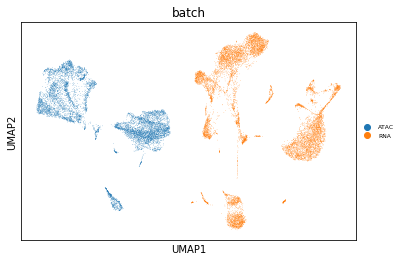

In [253]:
sc.pl.umap(train, color = ['batch'], size = 1, legend_fontsize = 6, color_map = 'RdPu')

### Run scgen

In [254]:
train_scgen = train.copy()

In [256]:
tf.reset_default_graph()
network = scgen.VAEArith(x_dimension = train_scgen.shape[1], model_path = "/home/jovyan/10X_data/scgen_PBMC")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [258]:
network.train(train_data = train_scgen, n_epochs = 10)

In [260]:
corrected_adata = scgen.batch_removal(network, train_scgen)

Trying to set attribute `.X` of view, making a copy.
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/scgen/models/util.py:313: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  corrected.obs = pd.concat([all_shared_ann.obs, all_not_shared_ann.obs])


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/jovyan/.local/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/jovyan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
... storing 'batch' as categorical
... storing 'cell_type' as categorical
... storing 'concat_batch' as categorical


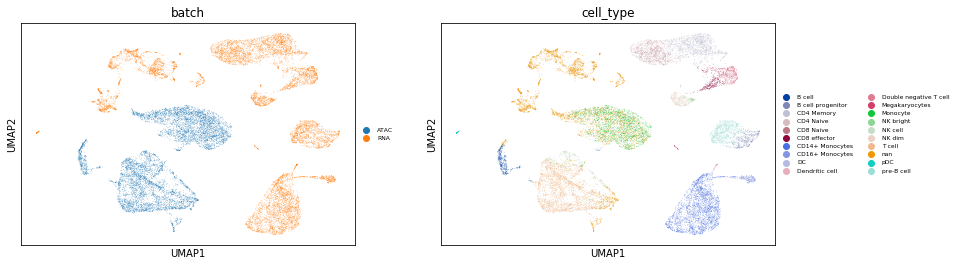

In [261]:
sc.pp.neighbors(corrected_adata, random_state = 1786)
sc.tl.umap(corrected_adata, min_dist = 0.3, spread = 1, random_state = 1786)
sc.pl.umap(corrected_adata, color = ['batch', 'cell_type'], size = 1, legend_fontsize = 6, color_map = 'RdPu')

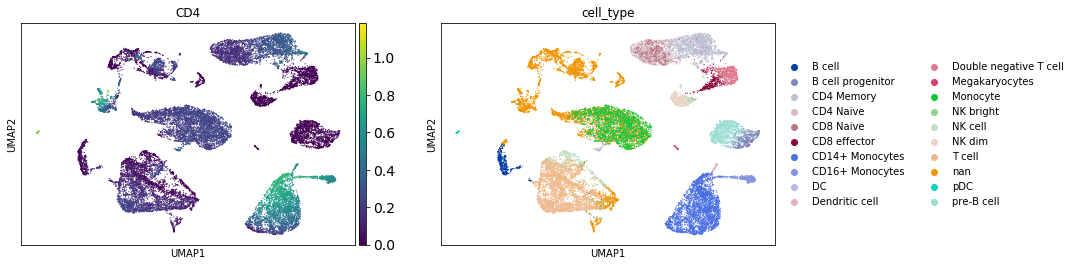

In [268]:
sc.pl.umap(corrected_adata, color=[ "CD4", "cell_type"])

In [272]:
train_scgen.shape

(20497, 19833)